## Machine Learning & AI

![Colegio Bourbaki](./Images/Bourbaki.png)

### Temporal Fussion Transformer

In [1]:
#!pip install --upgrade torch pytorch-lightning==1.9.4 pytorch-forecasting torchdata optuna

Vamos a utilizar la libreria pytorch-forecasting de la cual importaremos el modelo TFT. También puede utilizarse el modelo de la libreria neuralforecast de la empresa NIXTLA. Ambas se apalancan PyTorch Lightning

Links:

* **Pytorch Forecasting:** https://pytorch-forecasting.readthedocs.io/en/stable/index.html
* **Neural Forecast:** https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/introduction.html
* **Pytorch Lightning:** https://lightning.ai/docs/pytorch/stable/

Librerias

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Pytorch Lighting
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

# Pytorch Forcasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import  QuantileLoss, MAE, RMSE, SMAPE, MAPE, MASE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Utils
import pickle
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


No vamos a explicar nuevamente el contexto del problema, iremos directamente a la solución del problema ya planteado. La primera parte del código es similar, por lo tanto, muchas celdas no serán descriptas.

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
device

device(type='cuda')

Carga de Datos

In [4]:
x_train = pd.read_csv('./Data/SNCF/hard/Xtrain_hgcGIrA.csv')

In [5]:
index = x_train.index

In [6]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 2.8+ MB


In [7]:
df_x_train = x_train.copy(deep=True)

In [8]:
y_train = pd.read_csv(
    "/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/Data/SNCF/hard/Ytrain_yL5OjS4.csv"
)

In [9]:
df_y_train = y_train[['p0q0']]
df_y_train = df_y_train.set_index(index, drop=True)

In [10]:
df_x_train

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN


In [11]:
df_x_train['train'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54, 55,
        6,  7,  8,  9])

In [12]:
df_x_train['train'].nunique()

55

In [13]:
df_x_train["station"].unique()

array(['AD', 'AI', 'AJ', 'AK', 'AM', 'AT', 'AW', 'AX', 'BB', 'BD', 'BE',
       'AE', 'AL', 'AO', 'AQ', 'BC', 'AB', 'AN', 'AS', 'BF', 'BG', 'BH',
       'AV', 'AF', 'AP', 'AZ', 'AA', 'AC', 'AG', 'AH', 'AR', 'AU', 'BA',
       'BI', 'BJ', 'AY'], dtype=object)

In [14]:
df_x_train["station"].nunique()

36

In [15]:
df_train = pd.concat(
    [
        df_x_train,
        df_y_train
    ],
    axis=1,
)

In [16]:
df_train

,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106,0.216
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111,0.227
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108,0.229
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN,0.111
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN,0.143
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN,0.139
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN,0.117


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
 12  p0q0         31119 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 3.1+ MB


In [18]:
df_train.isna().sum()

date              0
train             0
way               0
station           0
hour           3204
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
p0q0              0
dtype: int64

In [19]:
df_train['hour'].value_counts(dropna=False)

hour
07:00:00    10064
08:00:00    10028
06:00:00     4995
NaN          3204
09:00:00     2826
11:00:00        2
Name: count, dtype: int64

In [20]:
#Fill 'hour' nan valuee with -1
df_train['hour'] = df_train['hour'].fillna(-1)

In [21]:
df_train['hour'] = df_train['hour'].apply(lambda x: '10:00:00' if x == -1 else x)

In [22]:
df_train["date"] = pd.to_datetime(df_train["date"], format="mixed")
df_train["hour"] = pd.to_datetime(df_train["hour"], format="%H:%M:%S").dt.hour

In [23]:
# Extract day of week and month as features
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['month'] = df_train['date'].dt.month

In [24]:
df_train['train'] = df_train['train'].astype("str")
df_train["station"] = df_train["station"].astype("str")
df_train["way"] = df_train["way"].astype("str")
df_train["composition"] = df_train["composition"].astype("str")
df_train = df_train.rename(columns={"train": "train_id"})

In [25]:
df_train.isna().sum()

date              0
train_id          0
way               0
station           0
hour              0
composition       0
p1q0           2052
p2q0           4145
p3q0           6184
p0q1           3202
p0q2           6399
p0q3           9592
p0q0              0
day_of_week       0
month             0
dtype: int64

Vamos a crear una nueva columna llamada time_idx donde aisgnaremos cada fila en datos un índice basado en la posición de su valor de fecha (date) dentro dela variable de una lista (lista).

In [27]:
# First, sort the data by date and hour to ensure correct temporal ordering
df_train = df_train.sort_values(by=["date", "hour"]).reset_index(drop=True)

# Create a unique time index within each group of (train, station)
df_train["time_idx"] = df_train.groupby(["train_id", "station"]).cumcount()

El time_idx es un componente crucial a la hora de preparar datos para modelos de series temporales, especialmente en el contexto de la TFT y la biblioteca pytorch-forecasting. Sirve para varios propósitos importantes:

* Orden temporal: Proporciona un índice numérico secuencial que representa el orden de los pasos temporales en los datos.
* Alinear secuencias: Ayuda a alinear correctamente las secuencias para las partes codificadora (encoder) y decodificadora (decoder) del modelo.
* Manejo de múltiples series temporales: Cuando se manejan múltiples series temporales (por ejemplo, diferentes trenes), asegura que los pasos temporales estén correctamente ordenados dentro de cada grupo.

**¿Por qué no utilizar directamente fechas o marcas de tiempo?**

Aunque las fechas y las marcas de tiempo contienen información temporal, pueden no ser adecuadas para indexar el tiempo en el modelo porque:
* Intervalos irregulares: Las fechas pueden no estar espaciadas por igual (por ejemplo, fines de semana, días festivos), lo que puede complicar el modelado secuencial.
* No numéricos: Los modelos requieren índices numéricos para los pasos temporales para realizar cálculos de forma eficiente.
* Complejidad: El cálculo de diferencias temporales y la alineación de secuencias mediante fechas pueden introducir una complejidad innecesaria.

In [28]:
df_train

,date,train_id,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0,day_of_week,month,time_idx
0,2019-01-07,1,0,AD,6,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216,0,1,0
1,2019-01-07,1,0,AI,6,2,0.097,0.166,NaN,0.216,0.230,0.201,0.275,0,1,0
2,2019-01-07,1,0,AJ,6,2,0.149,0.183,0.16800,0.216,0.275,0.230,0.282,0,1,0
3,2019-01-07,1,0,AK,6,2,0.044,0.148,NaN,0.216,0.201,0.138,0.230,0,1,0
4,2019-01-07,1,0,AM,6,2,NaN,NaN,NaN,0.138,0.091,0.084,0.201,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-20,50,0,AR,10,2,0.041,0.046,0.02400,NaN,NaN,NaN,0.022,0,5,56
31115,2019-05-20,51,0,AV,10,2,0.019,NaN,NaN,NaN,NaN,NaN,0.150,0,5,62
31116,2019-05-20,53,0,AV,10,2,0.041,0.061,0.13292,NaN,NaN,NaN,0.198,0,5,59
31117,2019-05-20,54,0,AV,10,2,0.061,0.056,0.19800,NaN,NaN,NaN,0.120,0,5,59


Comenzaremos a utilizar Pytorch Forecasting para resolver nuestro problema:

El siguiente paso es convertir el marco de datos en un PyTorch Forecasting TimeSeriesDataSet. Aparte de indicar al conjunto de datos qué características son categóricas frente a continuas y cuáles son estáticas frente a variables en el tiempo, también tenemos que decidir cómo normalizamos los datos. Aquí, normalizamos la escala de cada serie temporal por separado e indicamos que los valores son siempre positivos. Generalmente, se prefiere el EncoderNormalizer, que escala dinámicamente en cada secuencia del codificador a medida que se entrena, para evitar el sesgo look-ahead inducido por la normalización. Sin embargo, puede aceptar el sesgo de anticipación si tiene problemas para encontrar una normalización razonablemente estable, por ejemplo, porque hay muchos ceros en sus datos. O si espera una normalización más estable en la inferencia. En este último caso, se asegura de que no aprende saltos "raros" que no estarán presentes cuando ejecute la inferencia, entrenando así en un conjunto de datos más realista.

Primero veamos un poco de estadisticas del time_idx

In [29]:
# Count the range of time_idx for each train_id and station
time_idx_stats = df_train.groupby(["train_id", "station"])["time_idx"].agg(["min", "max", "count"])
time_idx_stats["range"] = time_idx_stats["max"] - time_idx_stats["min"]
print(time_idx_stats.head(), '\n')

# Summary statistics to see the distribution of time_idx ranges
print("Time_idx range statistics across groups:")
print(time_idx_stats["range"].describe())

                  min  max  count  range
train_id station                        
1        AD         0   57     58     57
         AI         0   57     58     57
         AJ         0   57     58     57
         AK         0   57     58     57
         AM         0   57     58     57 

Time_idx range statistics across groups:
count    541.000000
mean      56.521257
std        3.573308
min       48.000000
25%       54.000000
50%       57.000000
75%       59.000000
max       64.000000
Name: range, dtype: float64


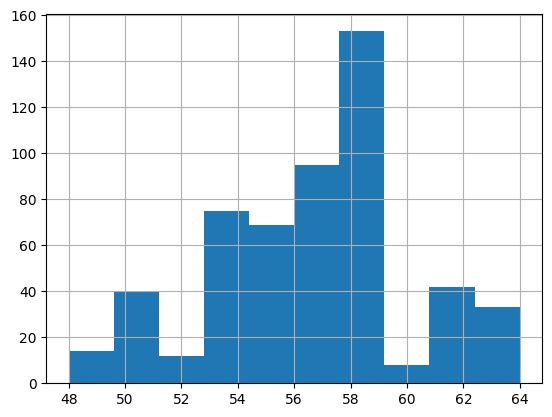

In [30]:
time_idx_stats['range'].hist()
plt.show()

In [31]:
# Count the number of stops (unique time_idx) per train and station
stops_per_train_station = df_train.groupby(["train_id", "station"])["time_idx"].nunique()
print("Stops per train-station pair:")
print(stops_per_train_station.describe())

Stops per train-station pair:
count    541.000000
mean      57.521257
std        3.573308
min       49.000000
25%       55.000000
50%       58.000000
75%       60.000000
max       65.000000
Name: time_idx, dtype: float64


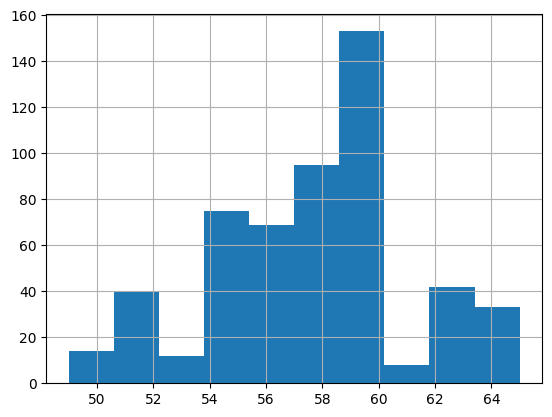

In [32]:
stops_per_train_station.hist()
plt.show()

In [33]:
df_train['time_idx'].value_counts()

time_idx
0     541
37    541
27    541
28    541
29    541
     ... 
60     83
61     75
62     60
63     33
64     10
Name: count, Length: 65, dtype: int64

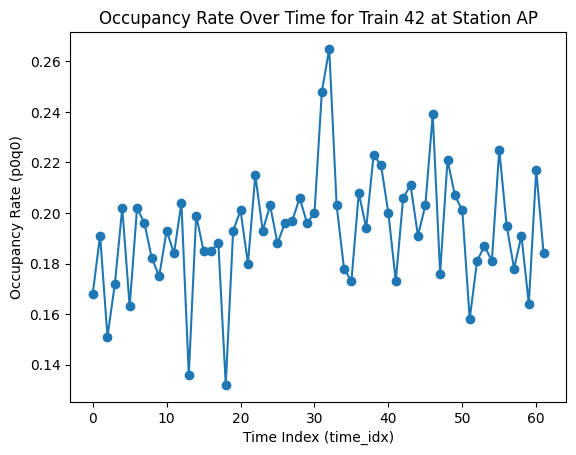

In [38]:
# Plot occupancy rates over time_idx for a specific train and station
sample_train_id = np.random.choice(df_train["train_id"].unique())  # Choose an example train randomly
sample_station = np.random.choice(df_train["station"].unique())  # Choose an example station randomly

sample_data = df_train[(df_train["train_id"] == sample_train_id) & (df_train["station"] == sample_station)]
plt.plot(sample_data["time_idx"], sample_data["p0q0"], marker="o")
plt.xlabel("Time Index (time_idx)")
plt.ylabel("Occupancy Rate (p0q0)")
plt.title(f"Occupancy Rate Over Time for Train {sample_train_id} at Station {sample_station}")
plt.show()

Observaciones de la Exploración de Datos

* Rango de time_idx (Contexto Histórico):

La mayoría de las combinaciones de tren-estación tienen entre 48 y 64 pasos de tiempo (time_idx) en el conjunto de datos.
El valor mediano (percentil 50) para el range es 57, lo que indica que la mayoría de los pares tren-estación tienen alrededor de 57 paradas.

* Longitud Típica de Secuencia (Paradas por Par Tren-Estación): El promedio de paradas es aproximadamente 57, y el máximo es 65.

In [39]:
# Define the lag columns with structural NaNs
lag_columns = ["p1q0", "p2q0", "p3q0", "p0q1", "p0q2", "p0q3"]

# Fill NaNs with -1 for these columns
df_train[lag_columns] = df_train[lag_columns].fillna(-1)

In [40]:
df_train.columns

Index(['date', 'train_id', 'way', 'station', 'hour', 'composition', 'p1q0',
       'p2q0', 'p3q0', 'p0q1', 'p0q2', 'p0q3', 'p0q0', 'day_of_week', 'month',
       'time_idx'],
      dtype='object')

In [41]:
max_encoder_length = 6 
max_prediction_length = 3
training_cutoff = df_train["time_idx"].max() - max_prediction_length

In [42]:
training_cutoff

61

El parámetro *max_encoder_length* especifica la longitud de la secuencia de entrada (también conocida como secuencia codificadora) que el modelo utiliza para hacer predicciones. En otras palabras, determina cuántos pasos temporales pasados tendrá en cuenta el modelo a la hora de pronosticar valores futuros.

En la arquitectura del Transformador de Fusión Temporal, los datos se procesan de secuencia a secuencia:
* Codificador: Procesa los datos históricos hasta el paso temporal actual. La longitud de esta secuencia viene determinada por max_encoder_length.
* Decodificador: Genera predicciones para futuros pasos temporales. La longitud del horizonte de predicción viene determinada por max_prediction_length.

**¿Cómo afecta *max_encoder_length* al modelo?**
* Ventana de contexto: Al establecer *max_encoder_length*, se define el tamaño de la ventana de contexto que tiene el modelo para aprender patrones a partir de datos históricos.
* Captura de dependencias temporales: Un *max_encoder_length* mayor permite al modelo captar dependencias y tendencias a largo plazo en los datos.
* Complejidad computacional: Aumentar *max_encoder_length* incrementa la carga computacional y el uso de memoria ya que el modelo tiene que procesar secuencias más largas.

In [43]:
training_dataset = TimeSeriesDataSet(
    df_train[df_train["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="p0q0",
    group_ids=["train_id", "station"],
    static_categoricals=["train_id", "station"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['time_idx', 'month', 'hour', "way", "composition", 'day_of_week'], 
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["p0q1", "p0q2", "p0q3", "p1q0", "p2q0", "p3q0",'p0q0'], # you can pass date in YYYYMMDD format, not timestamp
    #min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    #min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    variable_groups={},  # group of categorical variables can be treated as one variable
    target_normalizer=GroupNormalizer(
        groups=["train_id", "station"], transformation="softplus", scale_by_group=True
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    #randomize_length=True
)

Identificar tipos de variables
* *time_varying_known_reals*: Variables conocidas de antemano (por ejemplo, características de fecha).
* *time_varying_unknown_reals*: Variables que cambian con el tiempo pero que no se conocen de antemano (por ejemplo, variables de retardo).
* *static_categoricals*: Variables que son constantes para una serie temporal (por ejemplo, ID del tren ).

Link: https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet

In [44]:
training_dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'p0q0',
 'group_ids': ['train_id', 'station'],
 'weight': None,
 'max_encoder_length': 6,
 'min_encoder_length': 6,
 'min_prediction_idx': 0,
 'min_prediction_length': 3,
 'max_prediction_length': 3,
 'static_categoricals': ['train_id', 'station'],
 'static_reals': ['encoder_length', 'p0q0_center', 'p0q0_scale'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['time_idx',
  'month',
  'hour',
  'way',
  'composition',
  'day_of_week',
  'relative_time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['p0q1',
  'p0q2',
  'p0q3',
  'p1q0',
  'p2q0',
  'p3q0',
  'p0q0'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': True,
 'lags': {},
 'add_relative_time_idx': True,
 'add_target_scales': True,
 'add_encoder_length': True,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=['train_id', 'station'],
 	center=True,
 	scale_by_group=True,
 	transformat

In [45]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    df_train, 
    predict=True, 
    stop_randomization=True,
)

In [46]:
# create dataloaders for model
batch_size = 64
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=6)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=6)

Aquí estamos configurando un conjunto de datos para entrenar y validar un modelo de series temporales utilizando la biblioteca pytorch-forecasting, que es popular para tareas de predicción en series temporales con PyTorch.

A continuación, se detalla paso a paso lo que se está realizando:

  * Definición de Parámetros: Se establecen dos parámetros, max_prediction_length y max_encoder_length, que definen respectivamente la longitud máxima de la predicción y la longitud máxima del codificador (historia o contexto utilizado para la predicción).

  * Cálculo del Punto de Corte para el Entrenamiento: Se calcula training_cutoff para determinar hasta qué punto en el tiempo se incluirán los datos en el conjunto de entrenamiento. Esto se hace para asegurar que haya suficientes datos hacia el final del conjunto de datos para validar el modelo.

  * Creación del Conjunto de Datos para Entrenamiento (TimeSeriesDataSet):
      Se filtran los datos para incluir solo aquellos puntos en el tiempo que son iguales o anteriores al training_cutoff.
      Se especifican varias configuraciones importantes para el conjunto de datos, como los índices de tiempo (time_idx), la variable objetivo (target), los identificadores de grupo (group_ids), las longitudes mínima y máxima del codificador, y la longitud de la predicción.
      Se definen configuraciones adicionales como categorías estáticas y reales, variables conocidas y desconocidas tanto categóricas como reales, y se establece un normalizador de grupo para la variable objetivo.
      Se añaden características adicionales como el índice de tiempo relativo, las escalas del objetivo y la longitud del codificador.

  * Creación del Conjunto de Datos para Validación (TimeSeriesDataSet.from_dataset):
      Se crea un conjunto de datos para validación a partir del conjunto de entrenamiento, utilizando la totalidad de los datos pero configurando el conjunto para predecir los últimos max_prediction_length puntos para cada serie temporal.
      Esto permite evaluar cómo el modelo predice los datos "futuros" basándose en el conocimiento "pasado".

  * Creación de DataLoader para Entrenamiento y Validación:
      Se crean DataLoader para ambos conjuntos, permitiendo la carga eficiente de datos durante el entrenamiento y la validación del modelo en mini-lotes de tamaño batch_size.

Este proceso es típico en la preparación de datos para el entrenamiento de modelos de series temporales, permitiendo un manejo eficiente de diferentes longitudes de series, incorporación de variables explicativas y ajuste de parámetros específicos para la predicción temporal. La biblioteca pytorch-forecasting facilita la manipulación de series temporales complejas y la implementación de modelos de deep learning para su predicción.

Para determinar el valor adecuado de max_prediction_length para tu conjunto de datos, debes considerar el objetivo de tu análisis de series temporales y la naturaleza de los datos. El valor de max_prediction_length no se deriva directamente de los datos en sí, sino que es una elección que depende de cuánto en el futuro deseas predecir basado en la estructura temporal de tu conjunto de datos.

Ahora, pasaremos al modelo:

Vamos a calcular un benckmark base al cual deberíamos superar:

In [47]:
# calculate baseline errors, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(train_dataloader)])
baseline_predictions = Baseline().predict(train_dataloader, return_y=False, mode='prediction')

/tmp/ipykernel_2720510/1136779729.py:3: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(train_dataloader, return_y=False, mode='prediction')
/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ign

In [48]:
mae_baseline_predictions = MAE()(baseline_predictions.cpu(), actuals)
mape_baseline_predictions = MAPE()(baseline_predictions.cpu(), actuals)
smape_baseline_predictions = SMAPE()(baseline_predictions.cpu(), actuals)
rmse_baseline_predictions = RMSE()(baseline_predictions.cpu(), actuals)

In [49]:
# Print baseline errors
print("MAE:", mae_baseline_predictions.item())
print("MAPE:", mape_baseline_predictions.item())
print("SMAPE:", smape_baseline_predictions.item())
print("RMSE:", rmse_baseline_predictions.item())
print("MSE:", (rmse_baseline_predictions.item())**2)

MAE: 0.17587871849536896
MAPE: 2451.9140625
SMAPE: 0.742625892162323
RMSE: 0.2216036468744278
MSE: 0.04910817630804609


**Temporal Fusion Transformers**

Las previsiones multihorizonte a menudo contienen una compleja mezcla de variables de entrada - incluidas covariables estáticas (es decir, invariables en el tiempo), variables de entrada futuras conocidas y otras series temporales exógenas que solo se observan en el pasado - sin ninguna información previa sobre cómo interactúan con el objetivo. Se han propuesto varios métodos de aprendizaje profundo, pero suelen ser modelos de "caja negra" que no arrojan luz sobre cómo utilizan toda la gama de entradas presentes en escenarios prácticos.

El Transformador de Fusión Temporal (TFT), una arquitectura basada en la atención que combina la previsión multihorizonte de alto rendimiento con una visión interpretable de la dinámica temporal.

Para aprender las relaciones temporales a diferentes escalas, el TFT utiliza capas recurrentes para el procesamiento local y capas interpretables de autoatención para las dependencias a largo plazo.

TFT utiliza componentes especializados para seleccionar las características relevantes y una serie de capas de compuerta para suprimir los componentes innecesarios, lo que permite un alto rendimiento en una amplia gama de escenarios.

* Link: Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting - https://arxiv.org/pdf/1912.09363.pdf
* Link: https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html#pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer


Instanciamos el modelo:

In [50]:
# configure network and trainer
pl.seed_everything(42)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.1, # clipping gradients is a hyperparameter and important to prevent divergance of the gradient for recurrent neural networks
)

tft = TemporalFusionTransformer.from_dataset(
    training_dataset,  
    learning_rate=0.03, # not meaningful for finding the learning rate but otherwise very important
    hidden_size=16,  # most important hyperparameter apart from learning rate
    attention_head_size=1,  # number of attention heads. Set to up to 4 for large datasets
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4, # reduce learning rate if no improvement in validation loss after x epochs
    optimizer='adam'
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 31.8k


In [52]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1,
    min_lr=1e-6,
)

/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:11<00:00,  8.47it/s]
Learning rate set to 0.020892961308540386
Restoring states from the checkpoint path at /home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/.lr_find_f2b26258-86ea-471e-848d-9900de606732.ckpt
Restored all states from the checkpoint at /home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/.lr_find_f2b26258-86ea-471e-848d-9900de606732.ckpt


Suggested Learning Rate: 0.020892961308540386


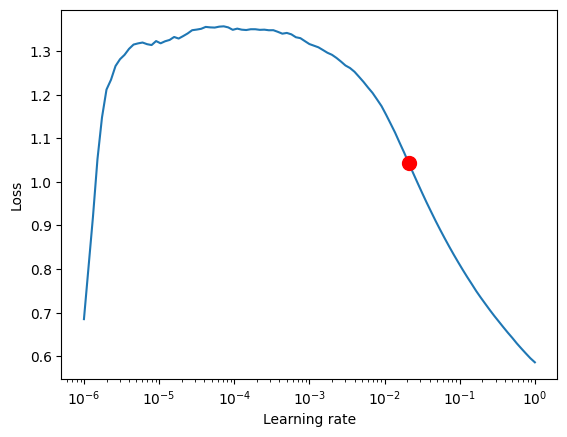

In [53]:
print(f"Suggested Learning Rate: {res.suggestion()}")
res.plot(show=True, suggest=True)
plt.show()

Para el TemporalFusionTransformer, la tasa de aprendizaje óptima es diferente a la sugerida.

A veces, no queremos utilizar directamente la tasa de aprendizaje sugerida porque PyTorch Lightning a veces puede confundirse por el ruido a tasas de aprendizaje más bajas y sugiere tasas demasiado bajas.

El control manual es esencial.

De todas maneras la tasa calculada se encuentra de valores conocidos, por lo tanto la usaremos

In [54]:
LR = res.suggestion()

In [55]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=LR,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
    optimizer='adam'
)

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu',   #Descomentar si hay GPU disponible
    devices=1,           #Descomentar si hay GPU disponible
    enable_model_summary=True,
    gradient_clip_val=1,
    #limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [56]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 31.8k


In [57]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 272    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 9.9 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Epoch 4: 100%|██████████| 417/417 [00:41<00:00, 10.14it/s, v_num=49, train_loss_step=0.0179, val_loss=0.0151, train_loss_epoch=0.0159]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 417/417 [00:41<00:00,  9.99it/s, v_num=49, train_loss_step=0.0179, val_loss=0.0151, train_loss_epoch=0.0159]


Vamos a realizar un fine-tuning de hiperparámetros:

**Optuna** es una biblioteca de optimización de hiperparámetros basada en Python diseñada para ser eficiente y flexible. Es particularmente útil en proyectos de machine learning, donde encontrar los mejores hiperparámetros puede ser una tarea compleja y costosa en cuanto a tiempo y recursos.

**Características principales:**

1) Optimización automatizada de hiperparámetros: Optuna permite realizar la búsqueda de hiperparámetros de forma automática y eficiente mediante estrategias de optimización como Tree-structured Parzen Estimator (TPE) y Sequential Halving.

2) Definición de búsqueda sencilla: En Optuna, la búsqueda se estructura en trials (pruebas), y se define una función objetivo que representa la métrica que queremos optimizar (por ejemplo, la precisión o el error de un modelo). Optuna ejecutará esta función varias veces, ajustando los hiperparámetros cada vez.

3) Exploración y explotación inteligente: Usa métodos avanzados que balancean entre probar nuevas configuraciones de hiperparámetros (exploración) y refinar configuraciones prometedoras (explotación), lo que reduce el tiempo y el costo computacional.

4) Soporte para paralelización y multihilo: La biblioteca es compatible con la ejecución de búsquedas en paralelo, lo que permite realizar múltiples pruebas simultáneamente en configuraciones de varios núcleos o en un clúster, mejorando la eficiencia en grandes proyectos.

5) Optimización distribuida: Para proyectos a gran escala, Optuna permite realizar búsquedas distribuidas, lo que facilita su integración en infraestructuras de computación en la nube o sistemas distribuidos.

6) Visualización y seguimiento: Optuna incluye herramientas de visualización para analizar el rendimiento de los trials y entender la convergencia de la optimización. Esto es útil para identificar patrones o configuraciones de hiperparámetros que producen buenos resultados.

In [58]:
# create study for hyperameter optimization
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1,
    max_epochs=1,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    #trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open(
    "/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/Data/Model/ModelDatatest_study.pkl",
    "wb",
) as fout:
    pickle.dump(study, fout)

[I 2024-10-30 20:19:10,473] A new study created in memory with name: no-name-d750bf87-b4cb-4224-bf1e-ef60daf7b750
/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

Veamos cuales son los hiperparámetros óptimos:

In [59]:
# show best hyperparameters
print(study.best_trial.params)

{'gradient_clip_val': 0.011204070456967679, 'hidden_size': 18, 'dropout': 0.24646091696280117, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.001534707854432141}


In [60]:
# load the best model according to the validation loss (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/pdconte/Desktop/Colegio_Bourbaki/ML_AI/Semana2/venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [61]:
# calculate mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [62]:
mae_predictions = MAE()(predictions.cpu(), actuals)
mape_predictions = MAPE()(predictions.cpu(), actuals)
smape_predictions = SMAPE()(predictions.cpu(), actuals)
rmse_predictions = RMSE()(predictions.cpu(), actuals)

In [63]:
#Print mae, mape, smape, rmse errors
print(f'MAE: {mae_predictions}')
print(f'MAPE: {mape_predictions}')
print(f'SMAPE: {smape_predictions}')
print(f'RMSE: {rmse_predictions}')
print(f'MSE: {(rmse_predictions)**2}')

MAE: 0.025703493505716324
MAPE: 0.12018699198961258
SMAPE: 0.11665383726358414
RMSE: 0.04271781072020531
MSE: 0.0018248113337904215


Comparemos con el baseline:

In [64]:
# Print baseline errors
print("MAE:", mae_baseline_predictions.item())
print("MAPE:", mape_baseline_predictions.item())
print("SMAPE:", smape_baseline_predictions.item())
print("RMSE:", rmse_baseline_predictions.item())
print("MSE:", (rmse_baseline_predictions.item())**2)

MAE: 0.17587871849536896
MAPE: 2451.9140625
SMAPE: 0.742625892162323
RMSE: 0.2216036468744278
MSE: 0.04910817630804609


Vamos a realizar predicciones:

Después del entrenamiento, podemos hacer predicciones con predict(). El método permite un control muy fino sobre lo que devuelve, de modo que, por ejemplo, puede hacer coincidir fácilmente las predicciones con su marco de datos de pandas. Evaluamos las métricas en el conjunto de datos de validación y en un par de ejemplos para ver lo bien que funciona el modelo.

In [65]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


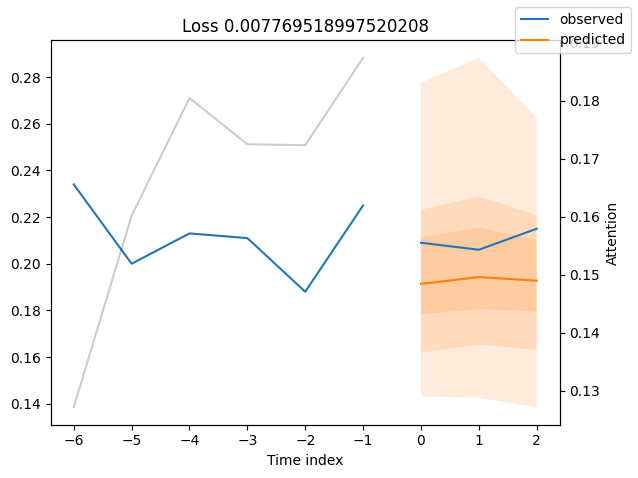

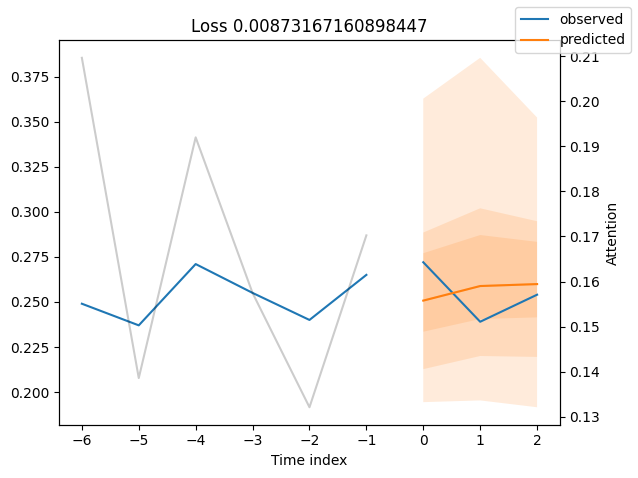

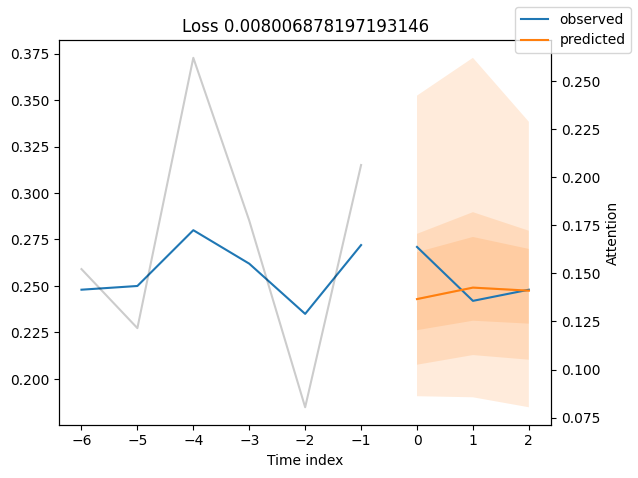

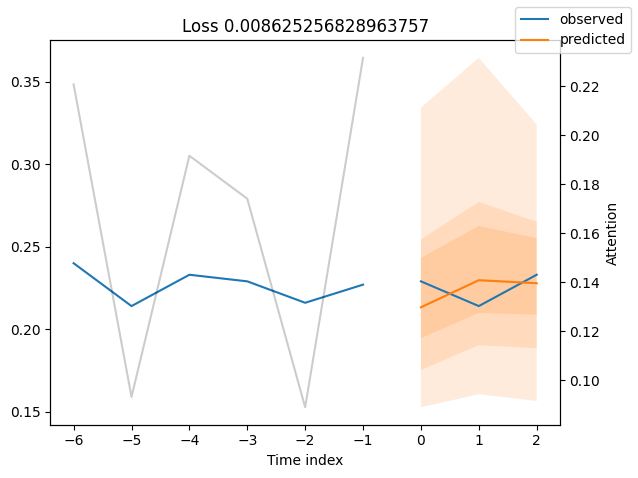

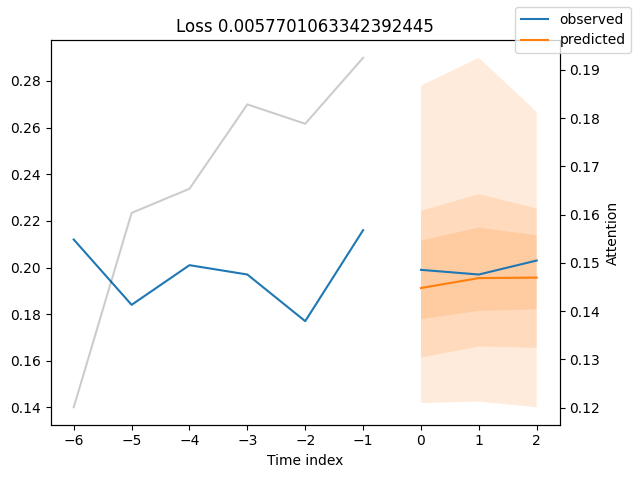

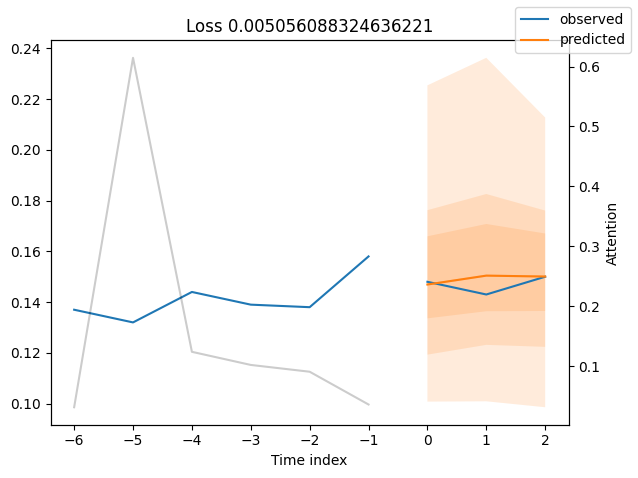

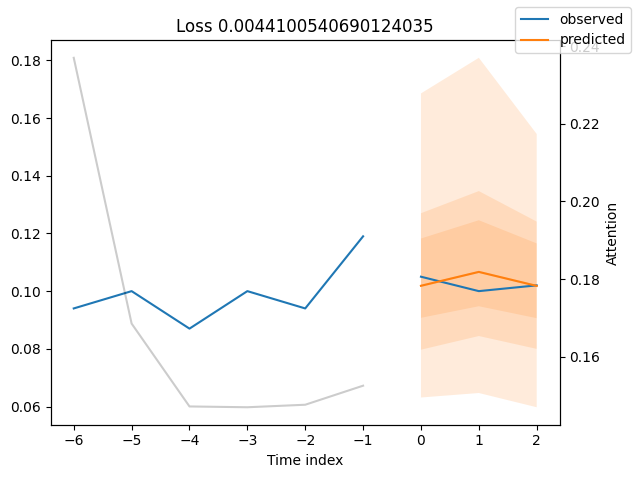

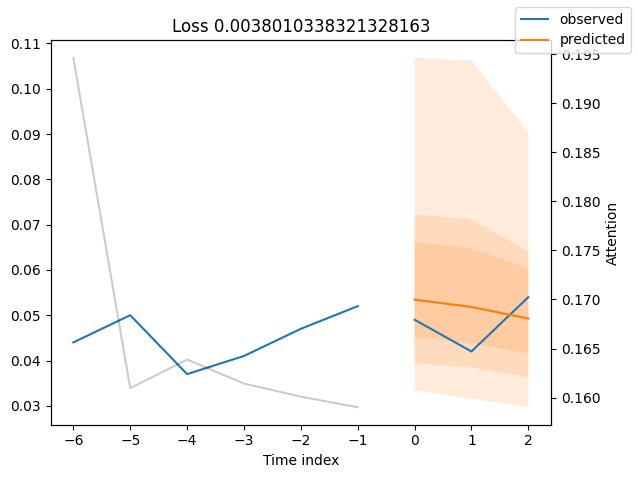

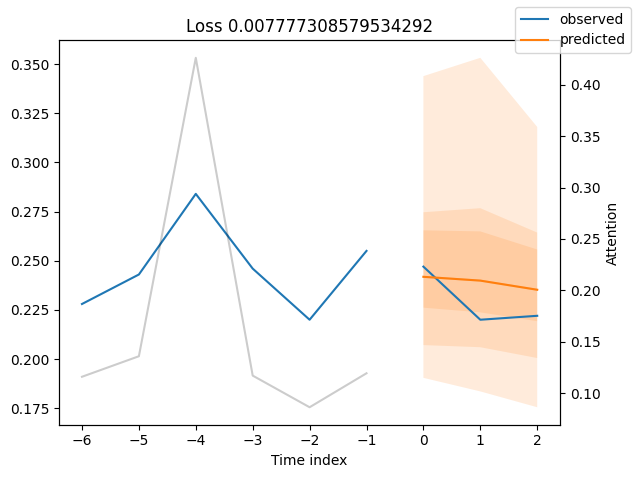

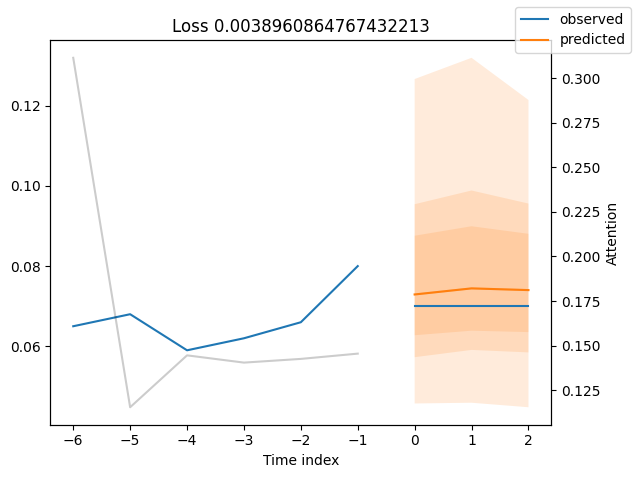

In [67]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

Comprobar cómo se comporta el modelo en distintos segmentos de datos nos permite detectar puntos débiles. Ahora podemos predecir directamente sobre los datos generados utilizando los métodos calculate_prediction_actual_by_variable() y plot_prediction_actual_by_variable(). Las barras grises denotan la frecuencia de la variable por bin, es decir, son un histograma.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


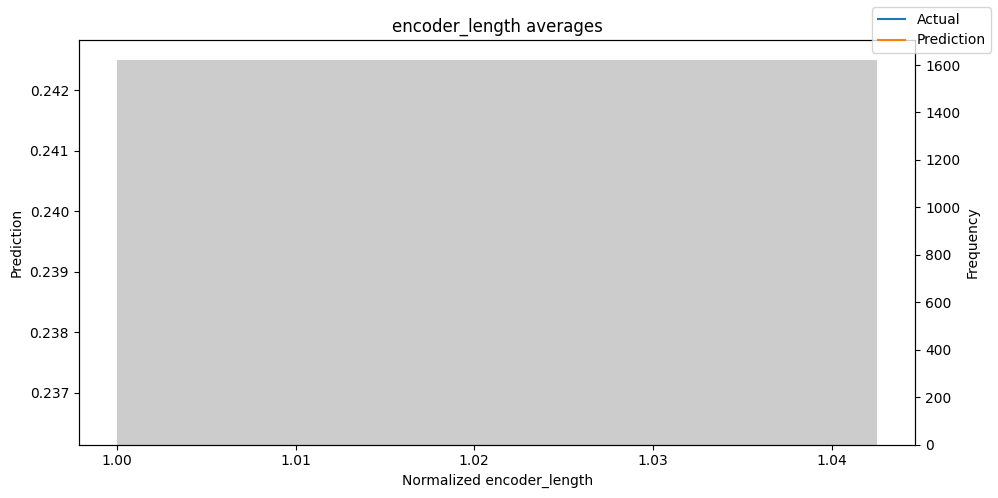

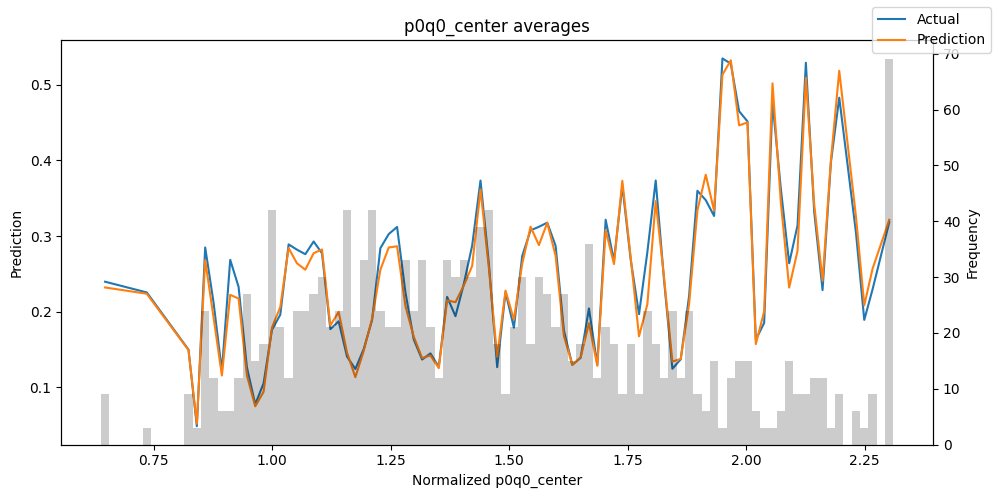

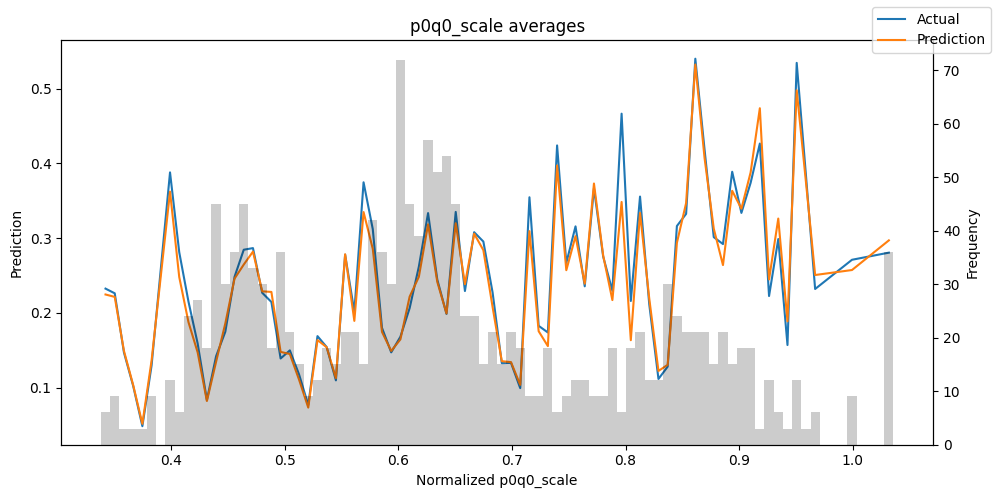

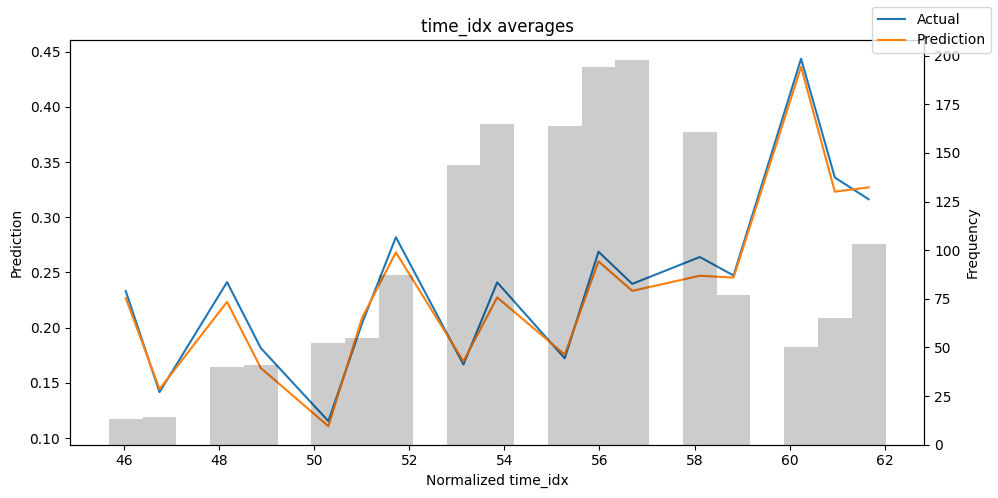

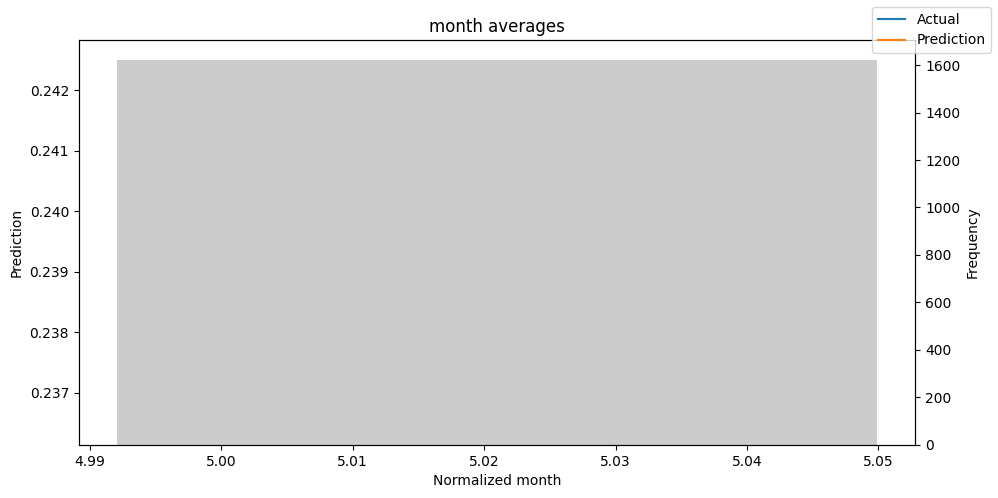

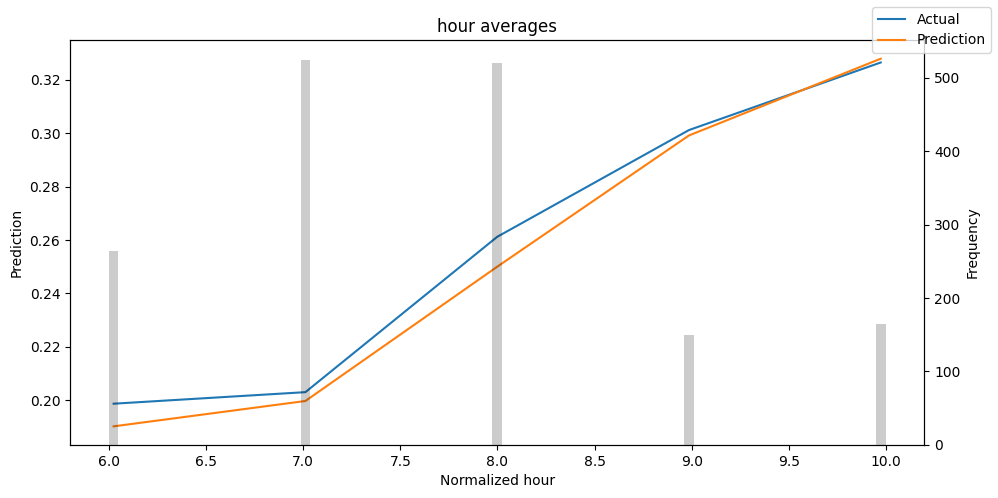

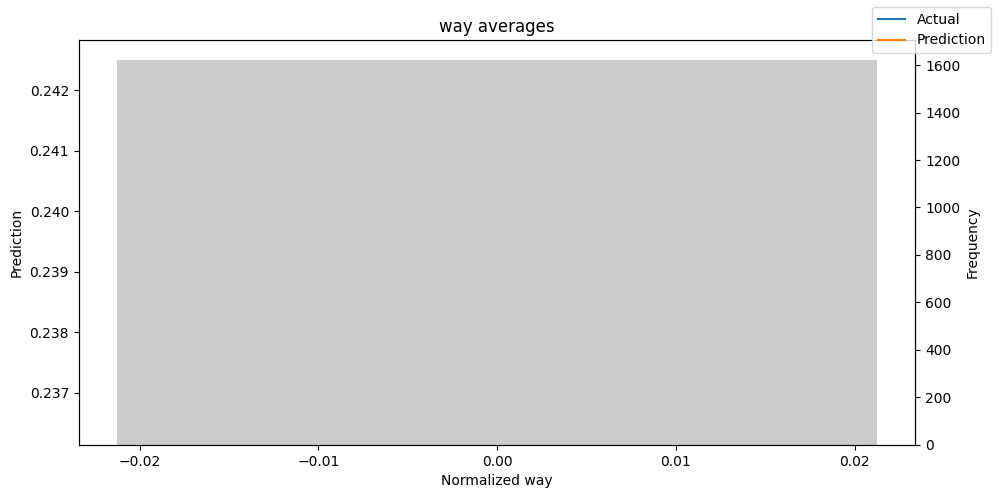

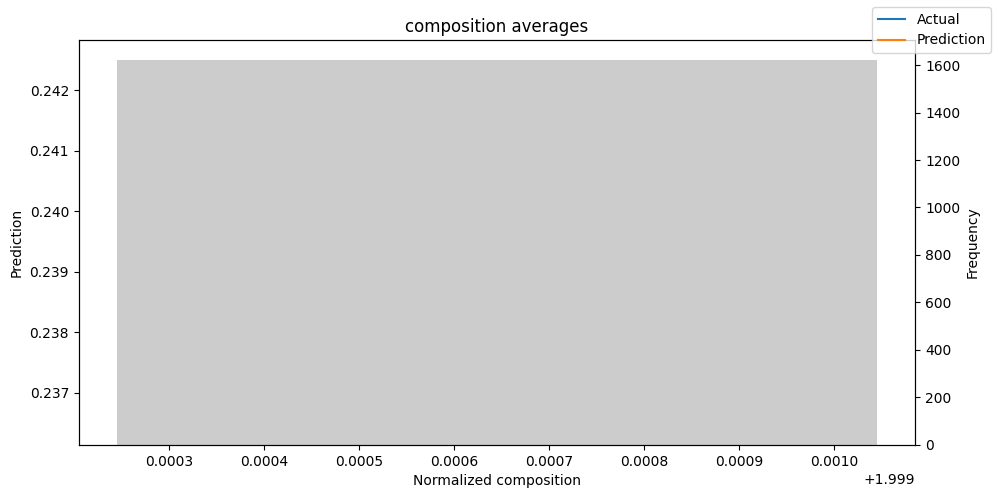

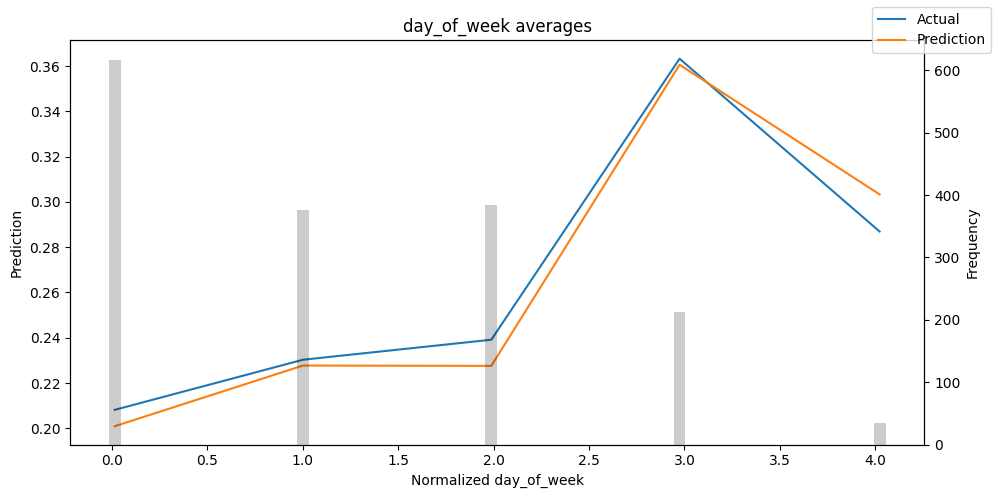

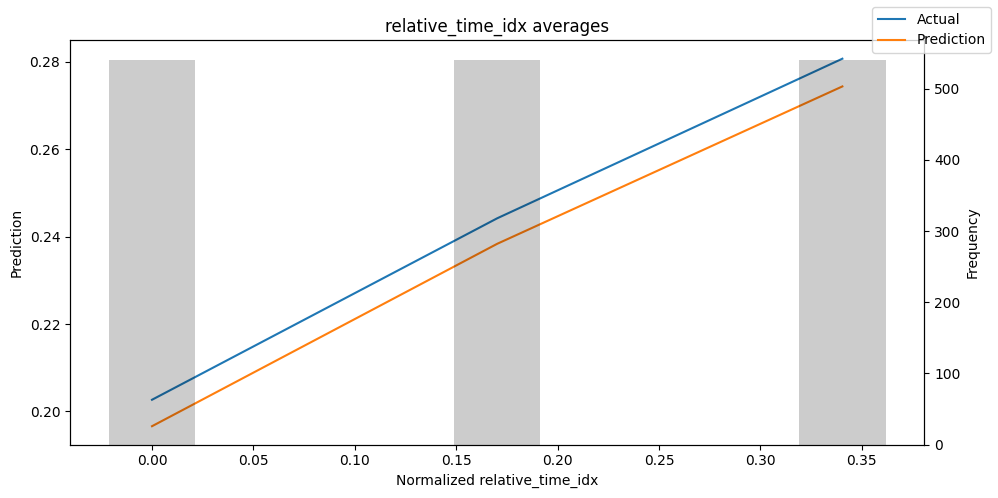

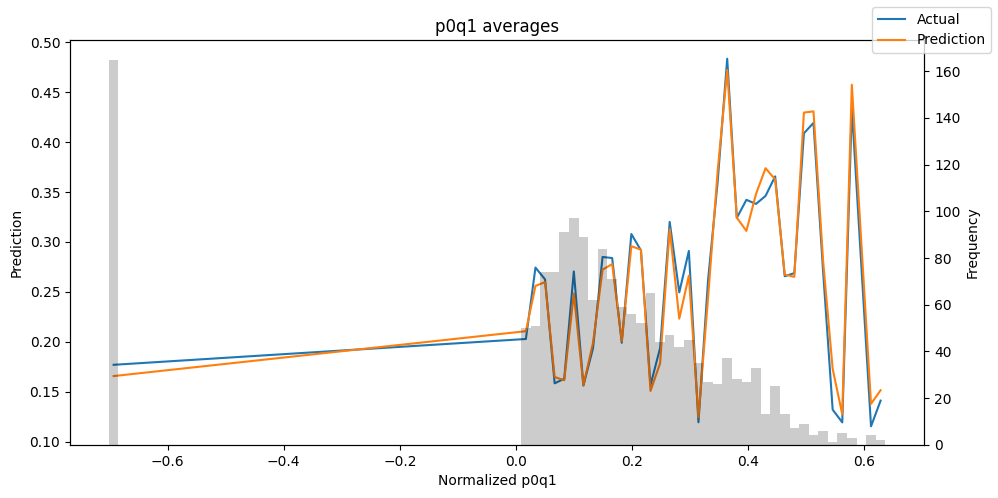

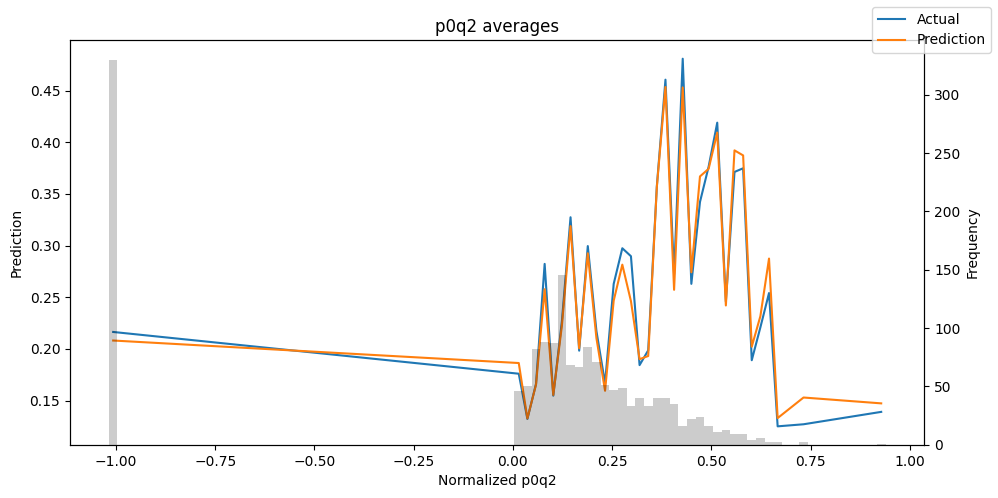

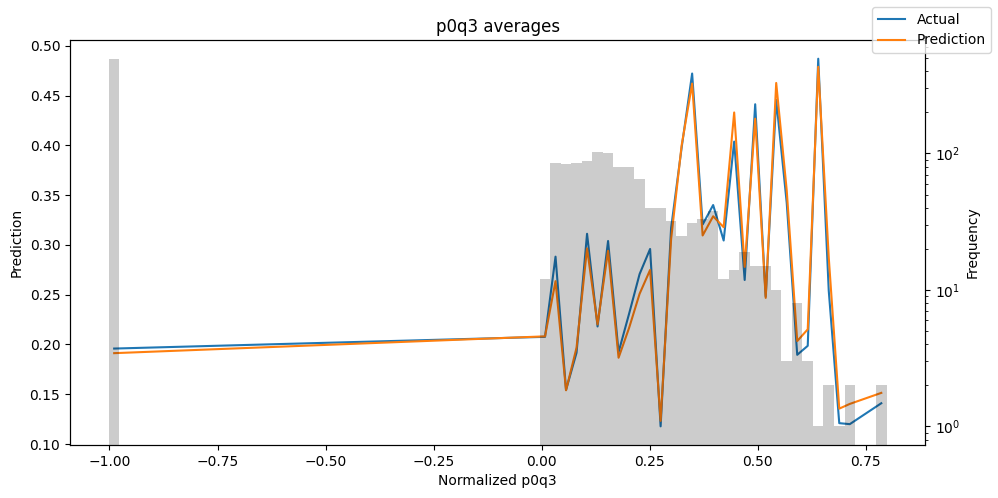

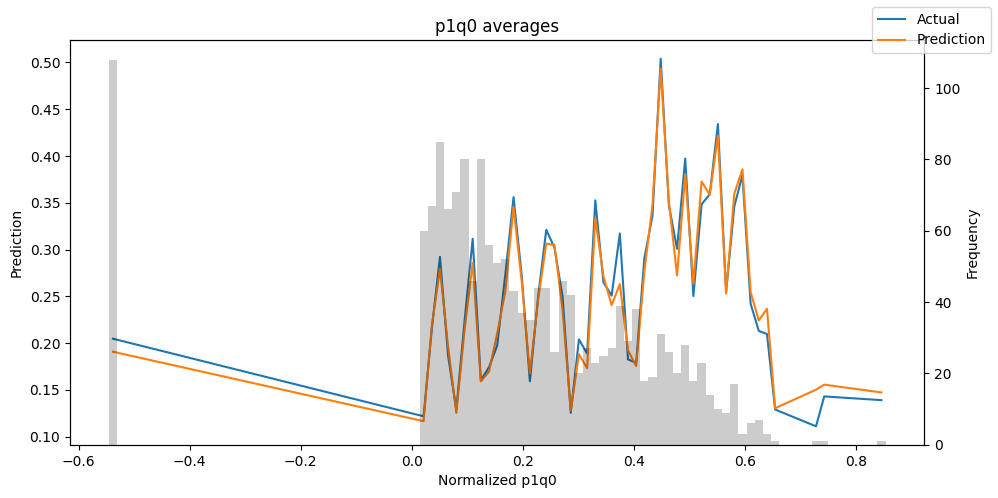

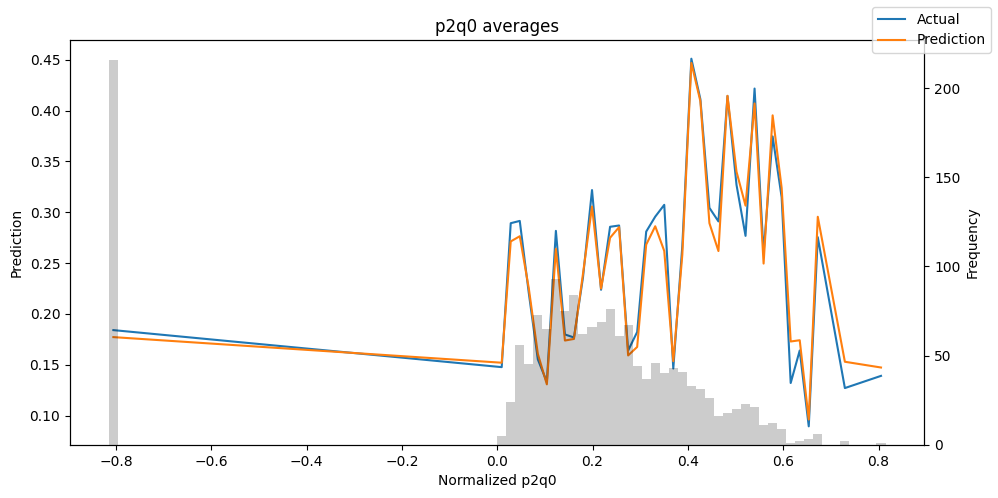

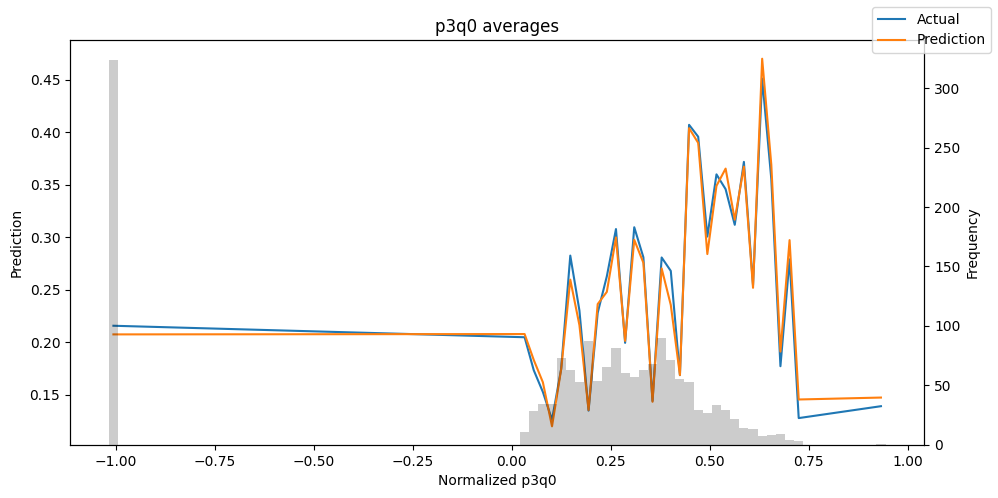

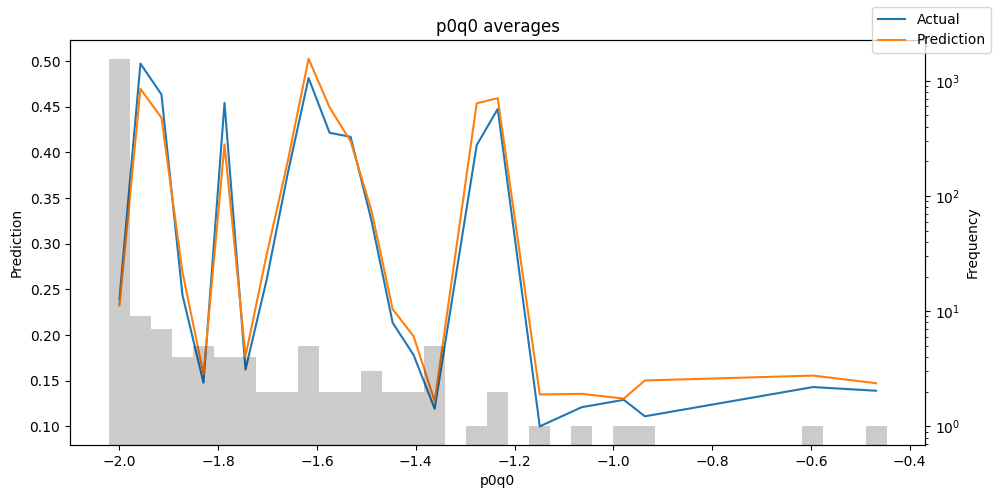

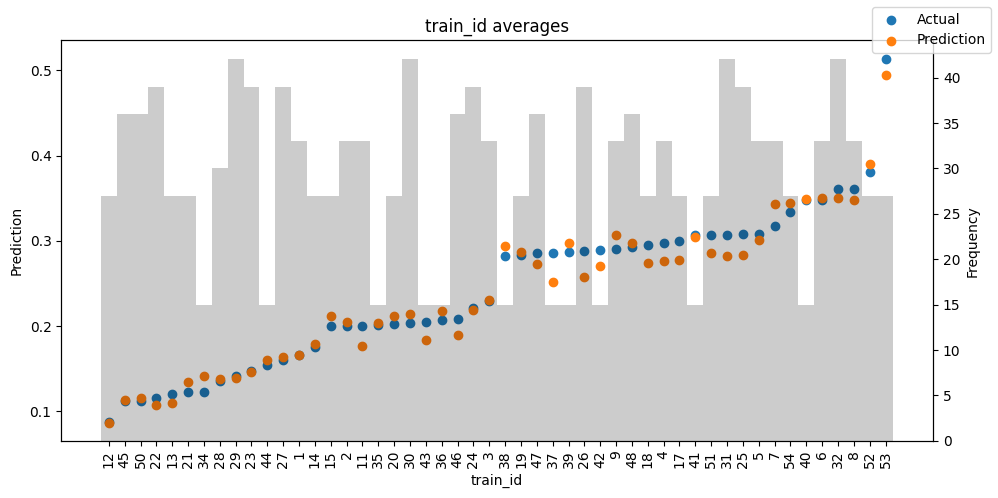

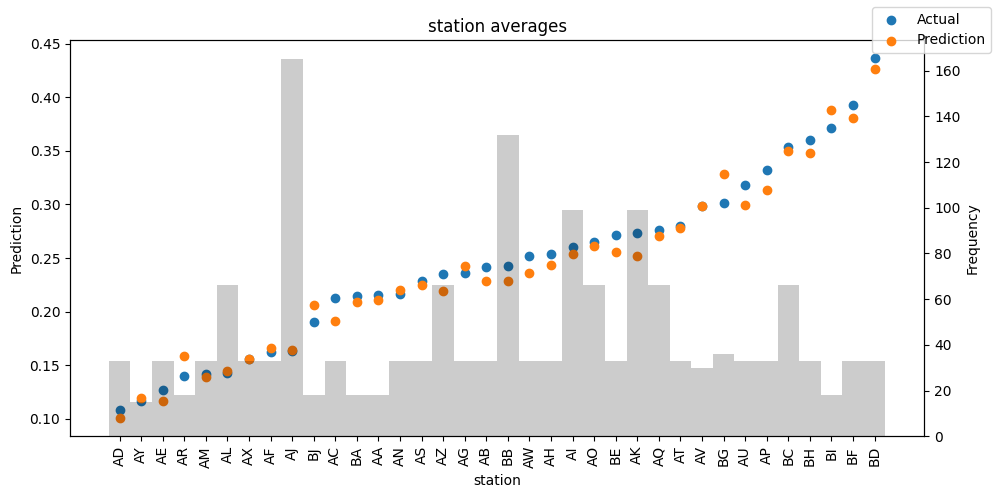

In [68]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)
plt.show()

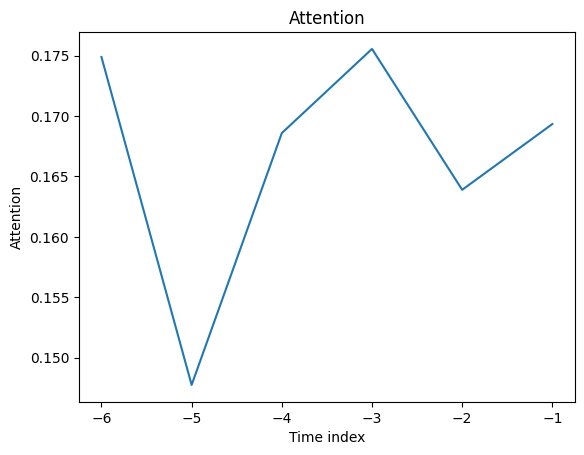

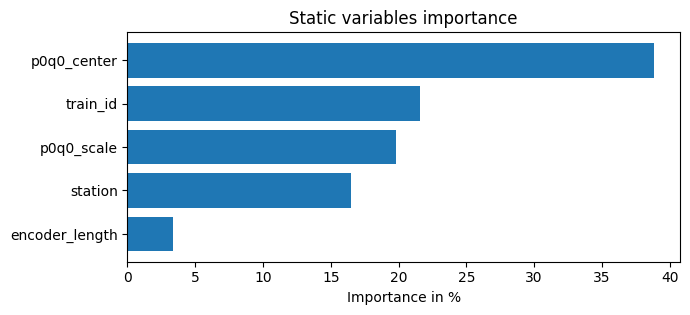

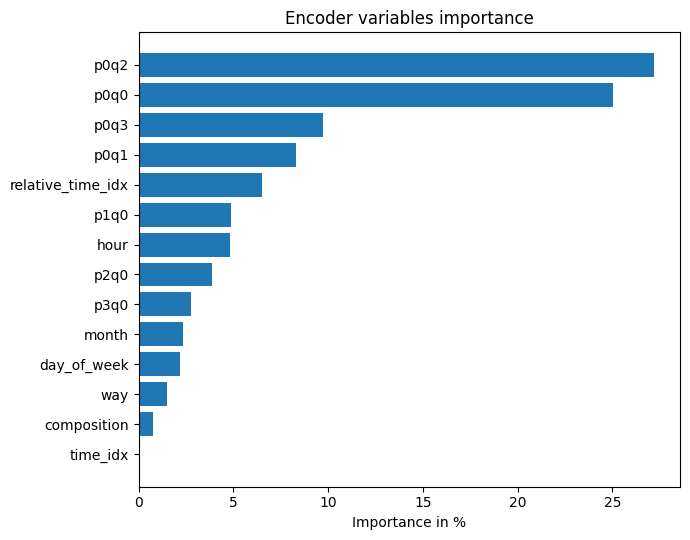

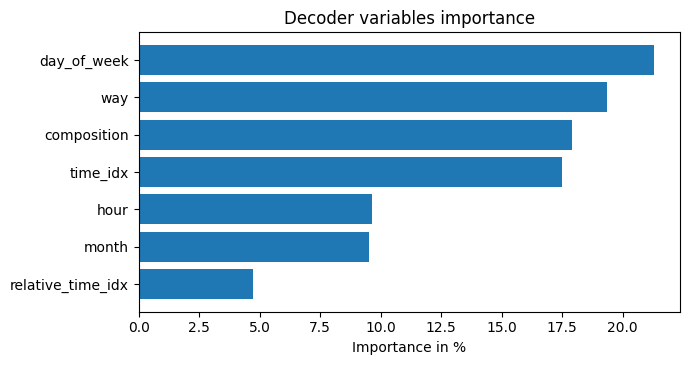

In [69]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)
plt.show()

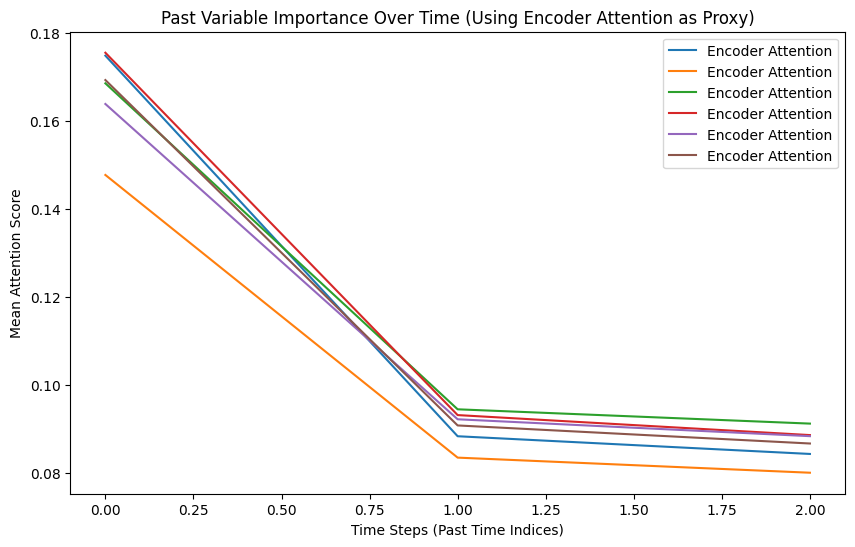

In [70]:
# Assume raw_predictions has an `encoder_attention` key
encoder_attention = raw_predictions.output.encoder_attention  # Shape should be (batch_size, max_encoder_length, num_attention_heads)

# Average across the batch and attention heads dimensions
mean_encoder_attention_over_time = encoder_attention.mean(dim=(0, 2)).detach().cpu().numpy()

# Create an array for time steps (assuming max_encoder_length is the length of time steps)
time_steps = np.arange(mean_encoder_attention_over_time.shape[0])

# Plot encoder attention over time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, mean_encoder_attention_over_time, label="Encoder Attention")
plt.xlabel("Time Steps (Past Time Indices)")
plt.ylabel("Mean Attention Score")
plt.title("Past Variable Importance Over Time (Using Encoder Attention as Proxy)")
plt.legend()
plt.show()


### Referencias:

* Introducing PyTorch Forecasting: https://towardsdatascience.com/introducing-pytorch-forecasting-64de99b9ef46

* Demand forecasting with the Temporal Fusion Transformer: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html#Hyperparameter-tuning

* Building Custom Models: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/building.html#passing-data

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)